In [1]:
import numpy as np
import psana as ps
import matplotlib.pyplot as plt
import sys
import time
import pickle
import os
from Functions import *
from raw_data_class import RawData as RDC
#from processed_data_class import ProData as PDC
%matplotlib notebook

In [2]:
save_dir = '/cds/home/b/bpoult/LCLS_LV_27_Data_Analysis/sample_data/'
calib_dir = '/cds/home/b/bpoult/LCLS_LV_27_Data_Analysis/calibrations/'
runs = list(range(207,214)) # goes from first value in range to last - 1
epix_roi = [80,140,170,330]
xrt_roi = [725,1500]
calibration_file = 'calibration_1'


# Processing or Loading
process_raw = False
on_off = True # Do you want to plot the raw data?
plot_one = 207
x_axis = 'energy' # 'pixels' or 'energy'
to_cal_file = [calib_dir, calibration_file]

In [3]:
# Energy Calibration, plot raw calibration runs with pixel axis and populate these arrays
save_cal = False

calib_runs = list(range(207,214))
notch_energies = [7.06,7.065,7.07,7.075,7.08,7.085,7.09] # keV
xrt_pixels = [1474,1385,1297,1216,1131,1048,966] # enter 0 if you can't see the notch
epix_pixels = [0,223,236,248,262,274,0] # enter 0 if you can't see the notch

labels = ['notch_energies','xrt_pixels','epix_pixels','rois','calibration_dir','calib_runs']
rois = [xrt_roi,epix_roi]
to_cal_file = [calib_dir, calibration_file]
calib_in = [labels, notch_energies,xrt_pixels,epix_pixels,rois,to_cal_file,calib_runs]
calib_out = energy_calib.energy_calib(calib_in,save_cal)

Overwrite calibration_1.pkl? (y/n)y
calibration_1.pkl has been saved.


exp=cxix46119:run=207:smd
exp=cxix46119:run=208:smd
exp=cxix46119:run=209:smd
exp=cxix46119:run=210:smd
exp=cxix46119:run=211:smd
exp=cxix46119:run=212:smd
exp=cxix46119:run=213:smd


<IPython.core.display.Javascript object>


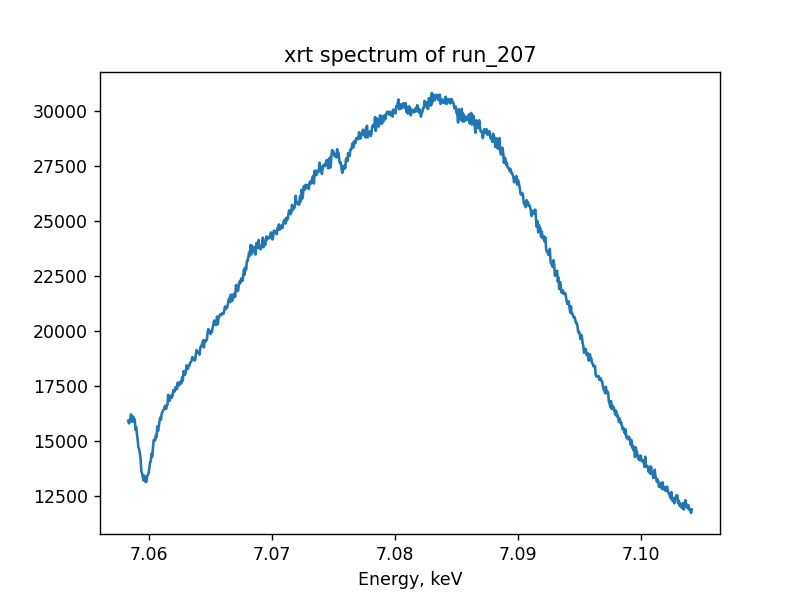

<IPython.core.display.Javascript object>


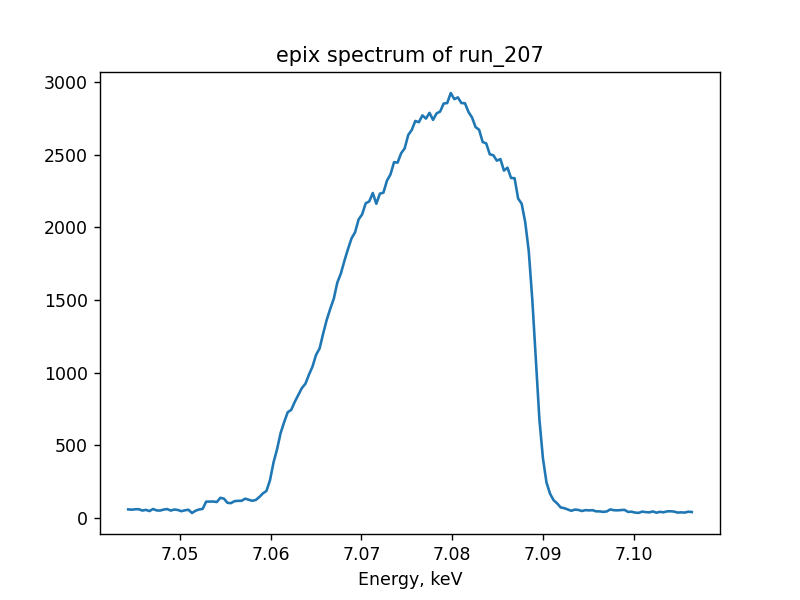

<IPython.core.display.Javascript object>


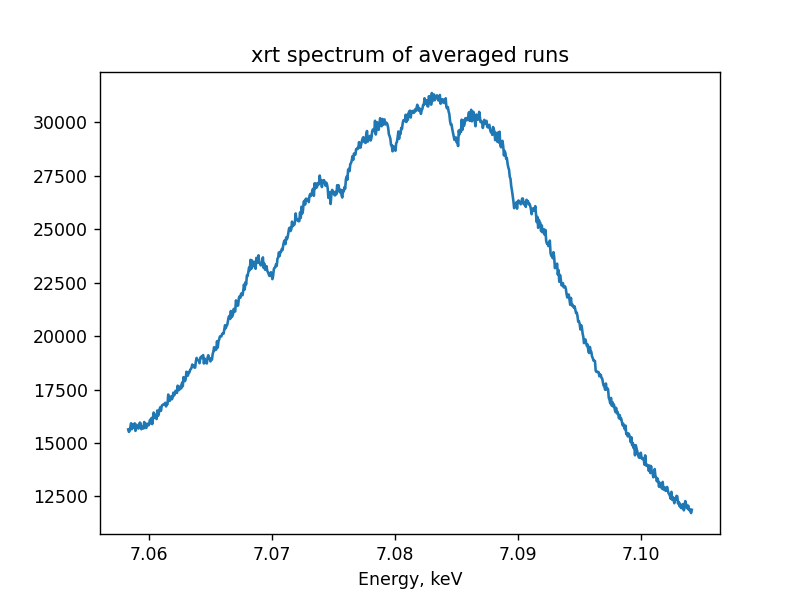

<IPython.core.display.Javascript object>


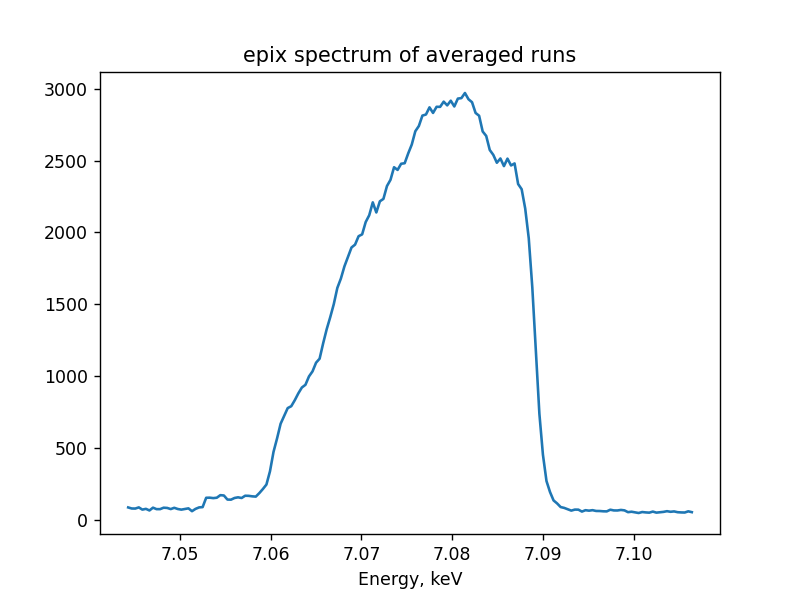

<IPython.core.display.Javascript object>


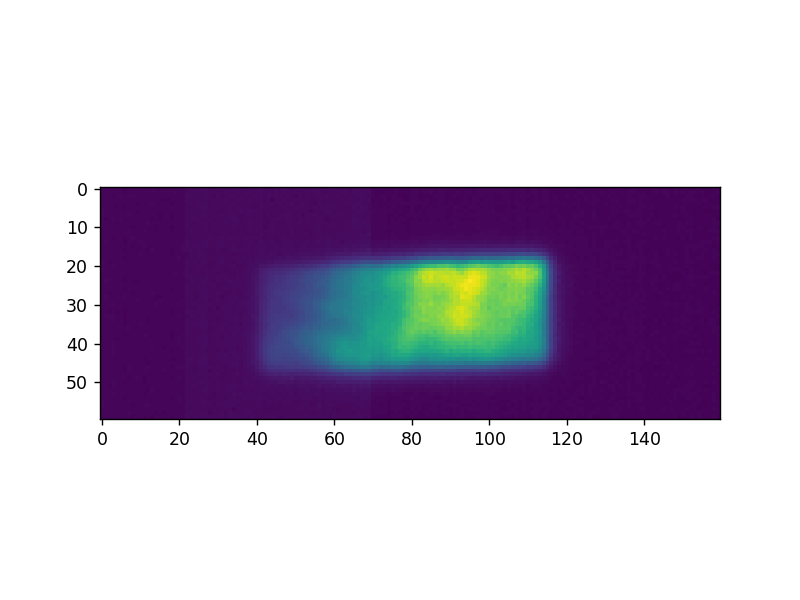

In [4]:
# Raw Data

raw_datas = []
for run in runs:
    scan_name = 'run_' + f'{run:03}'
    ds_string = 'exp=cxix46119:run='+str(run)+':smd'
    print(ds_string)
    if process_raw:
        raw_data = load_data.load_data(save_dir,scan_name,ds_string,epix_roi,xrt_roi)
    else:
        with open(save_dir + scan_name + "/" + "rawdata.pkl", "rb") as f:
            raw_data = pickle.load(f)
            
    raw_datas = raw_datas + [raw_data]

plot_raw.plot_raw(raw_datas, plot_one, x_axis, on_off,to_cal_file)

plt.figure()
plt.imshow(raw_data.avg_epix_2d)
plt.show()

In [10]:
# Filtering Raw Data: filter[0] = 'filter_name'
                    # filter[1] = True/False to turn on/off that filter
                    # filter[2:end] = 1 value per index
filter1 = ['xx',True,1,1,1,1]
filter2 = ['yy',True,2,2,2]
filter3 = ['zz',False,3]


filter_parameters = [filter1, filter2, filter3]
which_filters = [filter_parameters[i][1] for i in range(0,len(filter_parameters))]
filters_to_use = [filter_parameters[i] for i in range(0,len(filter_parameters)) if which_filters[i]==True]
filters_to_use

[['xx', True, 1, 1, 1, 1], ['yy', True, 2, 2, 2]]

In [ ]:
# Overlapping Data: matches energy ranges, resolutions, spectrometer response, and normalizes to upstream